In [100]:
# !pip install corner
# !pip install emcee

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

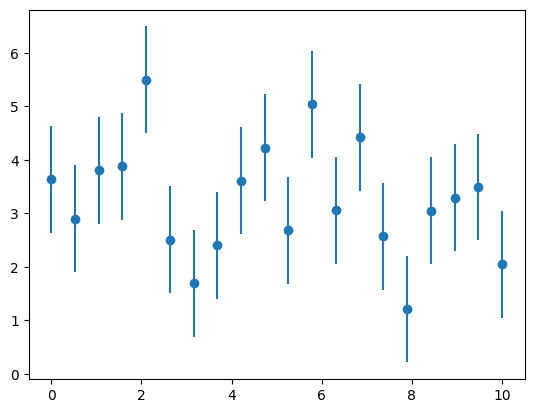

In [102]:
def model(x, params):
    k, b = params
    return k * x + b

def generate_data(params):
    params_line = [params[0], params[1]]
    error_scale = params[2]
    num = 20
    sigma = 1
    x = np.linspace(0, 10, num)
    y_model = model(x, params_line)
    y_data = y_model + \
             np.random.normal(0, sigma, num)
    sigma_list = sigma * error_scale * np.ones(num)
    return x, y_data, sigma_list

PARAMS_TRUE = [0, 3, 1]   # k, b, error_scale

x_list, y_data_list, sigma_list = \
    generate_data(PARAMS_TRUE)

plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o');

In [103]:
def gaussian(x, mu, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * \
           np.exp(-(x - mu)**2 / (2 * sigma**2))

In [104]:
def log_prior(pars):
    k, b, error_scale = pars
    if -10 < k < 10 and -10 < b < 10 and 0 < error_scale < 10:
        return 0 # np.log(1)
    return -np.inf # np.log(0)

In [105]:
def log_prob(pars, x_list, y_data_list, sigma_list):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf

    params_line = [pars[0], pars[1]]
    error_scale = pars[2]
    y_model_list = model(x_list, params_line)
    log_likelihood = 0
    for y_data, y_model, sigma in zip(y_data_list, y_model_list, sigma_list):
        likelihood = gaussian(y_data, y_model, sigma / error_scale)
        log_likelihood += np.log(likelihood)
    return lp + log_likelihood

pars_initial = np.array([0, 3, 1])   # (k, b) parameters of the line model

ndim = len(pars_initial)
nwalkers = 2 * ndim

start_pos = pars_initial + np.random.normal(0, 1e-10, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[x_list, y_data_list, sigma_list])
res = sampler.run_mcmc(start_pos, 3000)

In [106]:
samples = sampler.get_chain(flat=True)
samples.shape

(18000, 3)

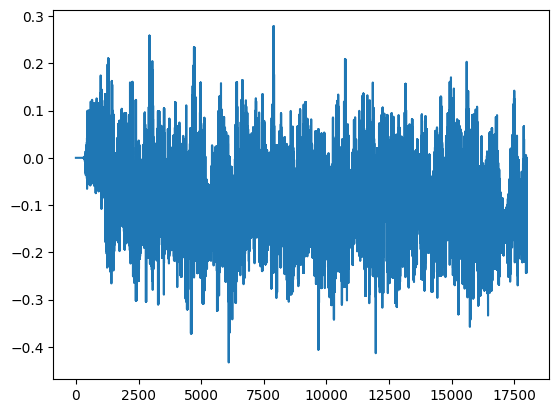

In [107]:
plt.plot(samples[:, 0]);

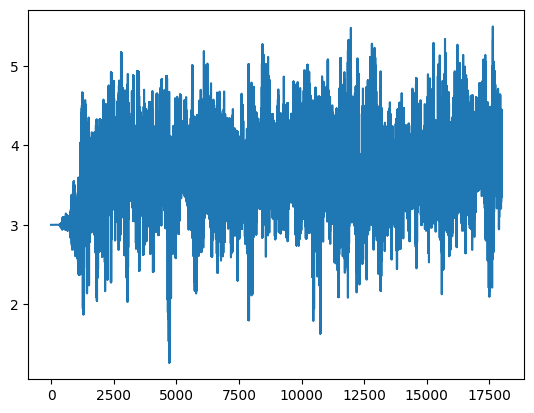

In [108]:
plt.plot(samples[:, 1]);

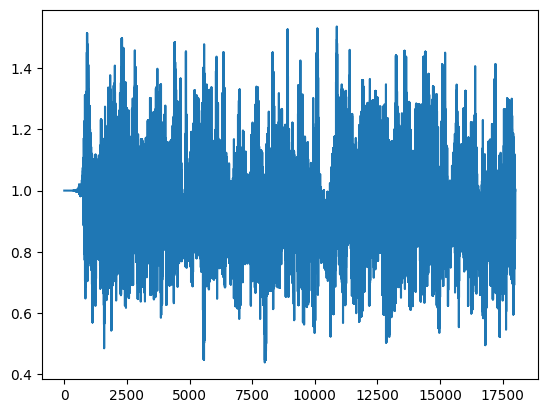

In [109]:
plt.plot(samples[:, 2]);

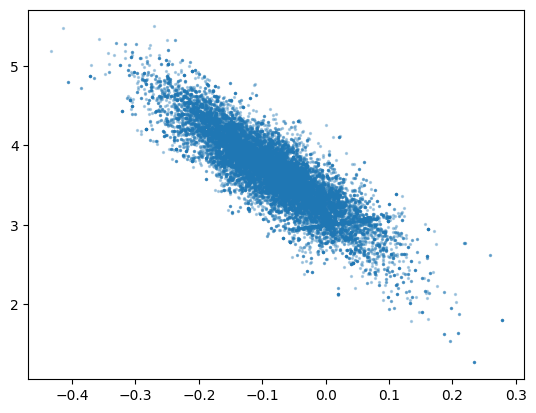

In [110]:
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.3);

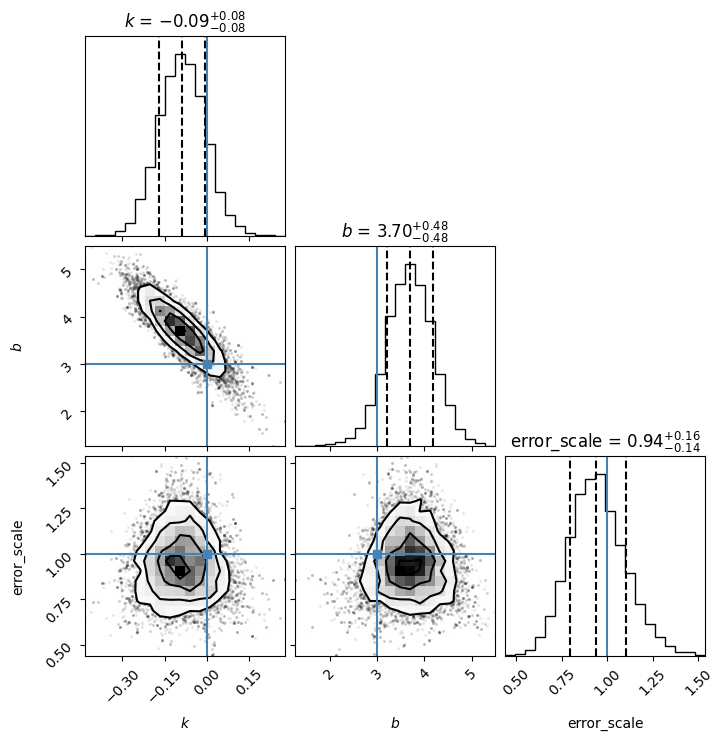

In [111]:
figure = corner.corner(
    samples[1000:],
    labels=[
        r"$k$",
        r"$b$",
        r"error_scale"
    ],
    truths=PARAMS_TRUE,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


In [112]:
# 20    - 0.075
# 200   - 0.02

# np.sqrt(200/20) * 0.02

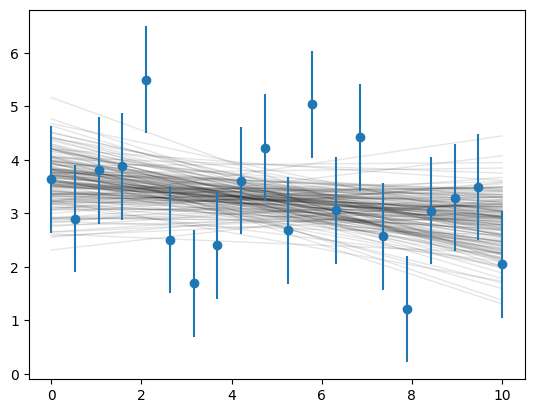

In [113]:
for k, b, error_scale in samples[1000:17000:100]:
    y_model = model(x_list, [k, b])
    plt.plot(x_list, y_model, c='k', alpha=0.1, lw=1)
plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o');